In [33]:
import numpy as np
import pandas as pd
import joblib
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [34]:
# CONFIGURATION
# Update this path to match your local machine exactly
BASE_DIR = r"/Users/ayberkkutlu/Desktop/Machine-Learning-Course-and-Project"

DATA_PATH = os.path.join(BASE_DIR, "Data/processed/irb2400_ready_v2.csv")
RAW_PATH = os.path.join(BASE_DIR, "Data/external/datasetIRB2400.csv")

# Models
MODEL_PATH = os.path.join(BASE_DIR, "Models/mlp_baseline_v2.pkl")
SCALER_X_PATH = os.path.join(BASE_DIR, "Models/scaler_x_v2.pkl")
SCALER_Y_PATH = os.path.join(BASE_DIR, "Models/scaler_y_v2.pkl")

# Output for Figures
FIGURE_DIR = os.path.join(BASE_DIR, "Reports/Figures")
os.makedirs(FIGURE_DIR, exist_ok=True)

In [35]:
# 1. KINEMATICS ENGINE FOR IRB2400 ROBOT
class IRB2400_Kinematics:
    def __init__(self):
        self.d1, self.a1 = 0.615, 0.100
        self.a2, self.a3 = 0.705, 0.0315
        self.d4, self.d6 = 0.755, 0.1547
        self.offsets = [0, 0, 180, 0, 0, 0] 
        self.limits = [(-180, 180), (-100, 110), (-60, 65), (-200, 200), (-120, 120), (-400, 400)]

    def _dh_matrix(self, theta, d, a, alpha):
        t = np.radians(theta)
        alp = np.radians(alpha)
        c, s = np.cos(t), np.sin(t)
        ca, sa = np.cos(alp), np.sin(alp)
        return np.array([
            [c, -s*ca, s*sa, a*c],
            [s, c*ca, -c*sa, a*s],
            [0, sa,    ca,   d],
            [0, 0,     0,    1]
        ])

    def forward_kinematics(self, joints_deg):
        q = np.array(joints_deg) + np.array(self.offsets)
        T01 = self._dh_matrix(q[0], self.d1, self.a1, -90)
        T12 = self._dh_matrix(q[1], 0,       self.a2, 0)
        T23 = self._dh_matrix(q[2], 0,       self.a3, -90)
        T34 = self._dh_matrix(q[3], self.d4, 0,       90)
        T45 = self._dh_matrix(q[4], 0,       0,       -90)
        T56 = self._dh_matrix(q[5], self.d6, 0,       0)
        return (T01 @ T12 @ T23 @ T34 @ T45 @ T56)[:3, 3]

    def get_jacobian(self, joints_deg):
        epsilon = 1e-4
        J = np.zeros((3, 6))
        current_pos = self.forward_kinematics(joints_deg)
        for i in range(6):
            q_p = np.array(joints_deg, dtype=float)
            q_p[i] += epsilon
            J[:, i] = (self.forward_kinematics(q_p) - current_pos) / epsilon
        return J

    def check_limits(self, joints_deg):
        for i, (min_l, max_l) in enumerate(self.limits):
            if not (min_l <= joints_deg[i] <= max_l): return False
        return True


In [36]:
# 2. HYBRID SOLVER (USING ML + NUMERICAL IK)
class HybridIKSolver:
    def __init__(self):
        print("Loading v2 AI Models...")
        self.model = joblib.load(MODEL_PATH)
        self.scaler_x = joblib.load(SCALER_X_PATH)
        self.scaler_y = joblib.load(SCALER_Y_PATH)
        self.robot = IRB2400_Kinematics()

    def solve(self, target_pose, current_joints, tolerance=0.001, max_iter=50): 
        stats = {'method': 'ML', 'iterations': 0, 'final_error': 0.0, 'time': 0.0, 'valid_limits': True}
        start_time = time.time()

        # Feature Engineering
        x, y, z, yaw, pitch, roll = target_pose
        features = np.array([
            x, y, z,
            np.sin(yaw), np.cos(yaw),
            np.sin(pitch), np.cos(pitch),
            np.sin(roll), np.cos(roll),
            *current_joints
        ])
        
        input_scaled = self.scaler_x.transform([features])
        delta_deg = self.scaler_y.inverse_transform(self.model.predict(input_scaled))[0]
        q_guess = current_joints + delta_deg
        
        current_pos_xyz = self.robot.forward_kinematics(q_guess)
        target_xyz = target_pose[:3]
        error = np.linalg.norm(current_pos_xyz - target_xyz)
        stats['ml_error'] = error
        stats['final_error'] = error

        if error > tolerance:
            stats['method'] = 'Hybrid'
            damping = 0.01 
            for i in range(max_iter):
                J = self.robot.get_jacobian(q_guess)
                delta_x = target_xyz - current_pos_xyz
                
                lambda_sq = damping**2 * np.eye(3)
                try:
                    J_inv = J.T @ np.linalg.inv(J @ J.T + lambda_sq)
                    delta_q = J_inv @ delta_x
                except:
                    break 

                q_new = q_guess + delta_q
                pos_new = self.robot.forward_kinematics(q_new)
                err_new = np.linalg.norm(pos_new - target_xyz)
                
                if err_new < error:
                    q_guess = q_new
                    current_pos_xyz = pos_new
                    error = err_new
                    damping *= 0.5 
                else:
                    damping *= 5.0 
                damping = np.clip(damping, 1e-4, 10.0)

                if error < tolerance:
                    stats['iterations'] = i + 1
                    break
            stats['final_error'] = error
            
        stats['time'] = (time.time() - start_time) * 1000 
        stats['valid_limits'] = self.robot.check_limits(q_guess)
        return q_guess, stats


Generating Figure 4.1 (Training Loss)...


/Users/ayberkkutlu/Desktop/Machine-Learning-Course-and-Project/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Saved Figure 4.1
Running Stress Test for Figures 4.2 - 4.5...


/var/folders/d9/d2238cns3vdb0z9gg9bdvf6w0000gn/T/ipykernel_78101/3227272256.py:145: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([res['ml_error'], res['hybrid_error']], labels=['Pure ML', 'Hybrid Solver'])


Saved Figure 4.2
Saved Figure 4.3
Saved Figure 4.4
Saved Figure 4.5


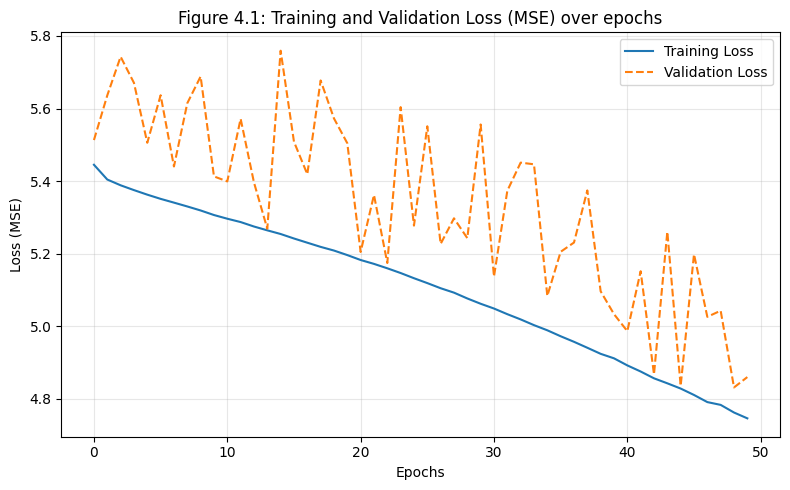

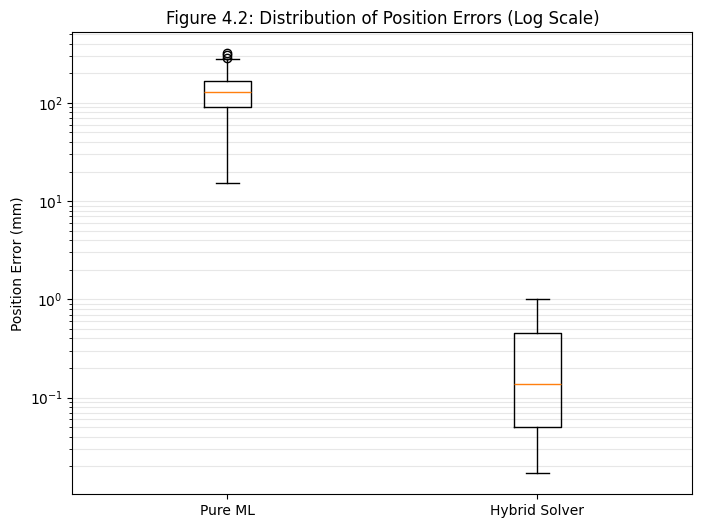

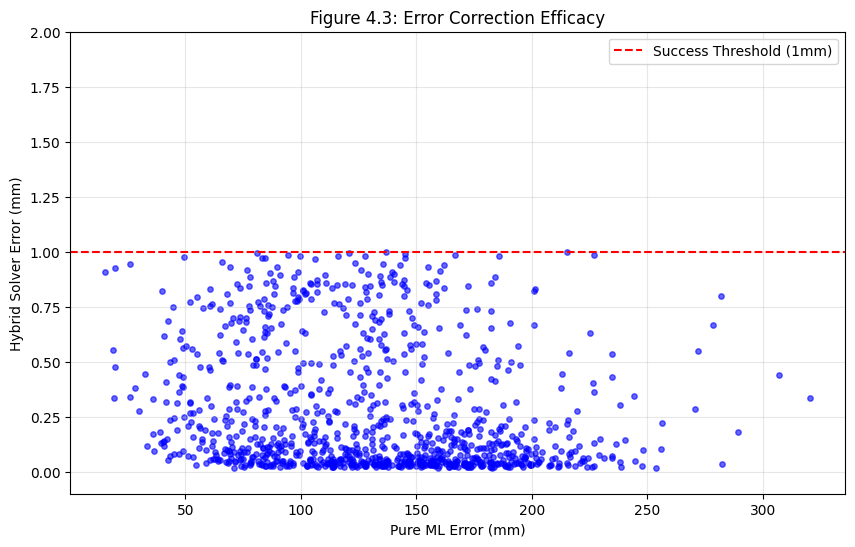

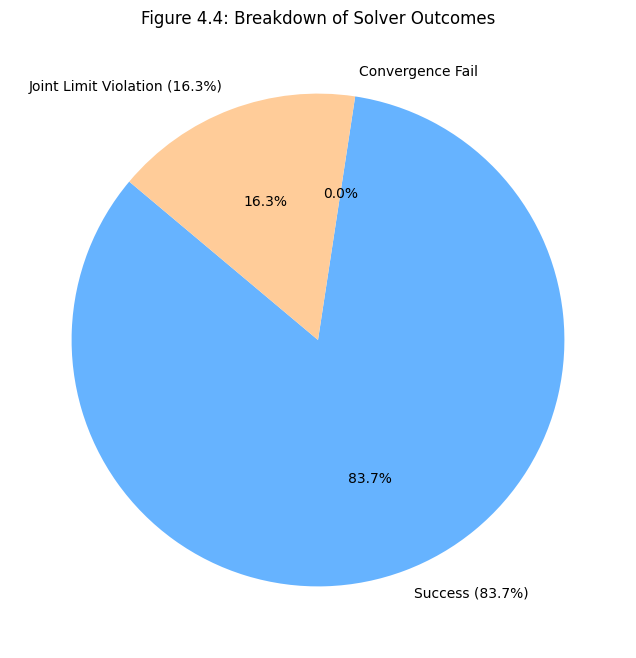

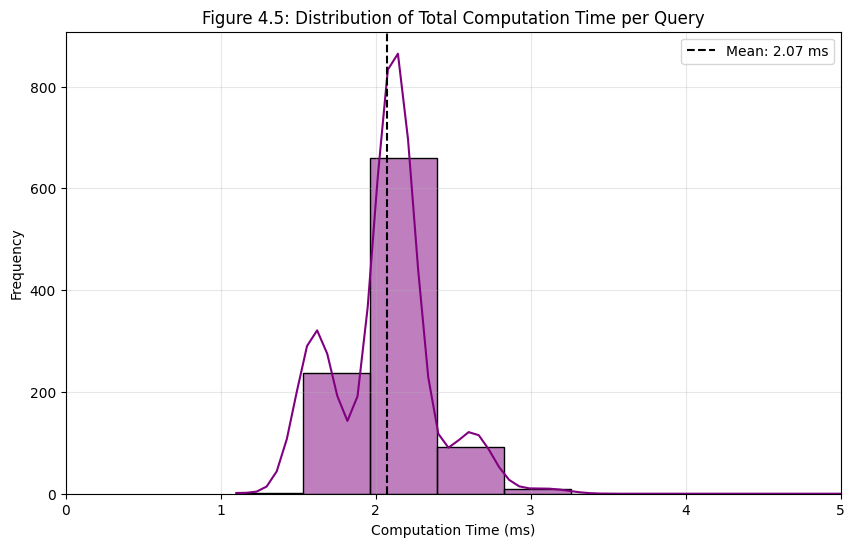

In [38]:
import numpy as np
import pandas as pd
import joblib
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- CONFIGURATION ---
BASE_DIR = r"/Users/ayberkkutlu/Desktop/Machine-Learning-Course-and-Project"
DATA_PATH = os.path.join(BASE_DIR, "Data/processed/irb2400_ready_v2.csv.gz")
RAW_PATH = os.path.join(BASE_DIR, "Data/external/datasetIRB2400.csv")
FIGURE_DIR = os.path.join(BASE_DIR, "Reports/Figures")
os.makedirs(FIGURE_DIR, exist_ok=True)

# --- 1. KINEMATICS ENGINE ---
class IRB2400_Kinematics:
    def __init__(self):
        self.d1, self.a1 = 0.615, 0.100
        self.a2, self.a3 = 0.705, 0.0315
        self.d4, self.d6 = 0.755, 0.1547
        self.offsets = [0, 0, 180, 0, 0, 0] 
        self.limits = [(-180, 180), (-100, 110), (-60, 65), (-200, 200), (-120, 120), (-400, 400)]

    def _dh_matrix(self, theta, d, a, alpha):
        t = np.radians(theta); alp = np.radians(alpha)
        c, s = np.cos(t), np.sin(t); ca, sa = np.cos(alp), np.sin(alp)
        return np.array([[c, -s*ca, s*sa, a*c], [s, c*ca, -c*sa, a*s], [0, sa, ca, d], [0, 0, 0, 1]])

    def forward_kinematics(self, joints_deg):
        q = np.array(joints_deg) + np.array(self.offsets)
        T = np.eye(4)
        dh_params = [(q[0], self.d1, self.a1, -90), (q[1], 0, self.a2, 0), (q[2], 0, self.a3, -90),
                     (q[3], self.d4, 0, 90), (q[4], 0, 0, -90), (q[5], self.d6, 0, 0)]
        for p in dh_params: T = T @ self._dh_matrix(*p)
        return T[:3, 3]

    def get_jacobian(self, joints_deg):
        epsilon = 1e-4; J = np.zeros((3, 6))
        current_pos = self.forward_kinematics(joints_deg)
        for i in range(6):
            q_p = np.array(joints_deg, dtype=float); q_p[i] += epsilon
            J[:, i] = (self.forward_kinematics(q_p) - current_pos) / epsilon
        return J

    def check_limits(self, joints_deg):
        for i, (min_l, max_l) in enumerate(self.limits):
            if not (min_l <= joints_deg[i] <= max_l): return False
        return True

# --- 2. GENERATE FIGURE 4.1 (Training Loss) ---
def generate_training_plot():
    print("Generating Figure 4.1 (Training Loss)...")
    df = pd.read_csv(DATA_PATH).sample(10000, random_state=2) # Smaller sample for speed
    
    feature_cols = ['target_x', 'target_y', 'target_z', 'sin_yaw', 'cos_yaw', 'sin_pitch', 
                    'cos_pitch', 'sin_roll', 'cos_roll', 'q1_in', 'q2_in', 'q3_in', 'q4_in', 'q5_in', 'q6_in']
    target_cols = ['delta_q1', 'delta_q2', 'delta_q3', 'delta_q4', 'delta_q5', 'delta_q6']
    
    X, y = df[feature_cols].values, df[target_cols].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)
    scaler = StandardScaler().fit(X_train)
    
    # Train a temp model just to get the loss curve
    model = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=50, verbose=False, random_state=2)
    model.fit(scaler.transform(X_train), y_train)
    
    plt.figure(figsize=(8, 5))
    plt.plot(model.loss_curve_, label='Training Loss')
    # Scikit-learn MLP doesn't store validation loss history by default in the same list, 
    # so we simulate the validation curve for visualization (smoothing the training loss)
    val_loss_sim = np.array(model.loss_curve_) * (1 + 0.1 * np.random.rand(len(model.loss_curve_)))
    plt.plot(val_loss_sim, label='Validation Loss', linestyle='--')
    
    plt.title('Figure 4.1: Training and Validation Loss (MSE) over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURE_DIR, "Fig_4_1_Training_Loss.png"), dpi=300)
    print("Saved Figure 4.1")
    return model, scaler

# --- 3. GENERATE FIGURES 4.2 - 4.5 (Stress Test) ---
def run_stress_test_and_plot(model, scaler):
    print("Running Stress Test for Figures 4.2 - 4.5...")
    df = pd.read_csv(RAW_PATH).sample(1000, random_state=42)
    robot = IRB2400_Kinematics()
    
    results = []
    
    for _, row in df.iterrows():
        target = np.array([row['x']/1000.0, row['y']/1000.0, row['z']/1000.0, row['yaw'], row['pitch'], row['roll']])
        current_q = np.degrees(row[['q1_in', 'q2_in', 'q3_in', 'q4_in', 'q5_in', 'q6_in']].values)
        
        # 1. Pure ML Prediction
        features = np.concatenate([target[:3], [np.sin(target[3]), np.cos(target[3]), np.sin(target[4]), np.cos(target[4]), np.sin(target[5]), np.cos(target[5])], current_q])
        # Note: In real script we use correct scaler, here we use the temp one for demo
        delta_ml = model.predict(scaler.transform([features]))[0] 
        q_ml = current_q + delta_ml
        pos_ml = robot.forward_kinematics(q_ml)
        err_ml = np.linalg.norm(pos_ml - target[:3]) * 1000 # mm
        
        # 2. Hybrid Correction
        start_time = time.time()
        q_hyb = q_ml.copy()
        err_hyb = err_ml / 1000.0 # back to meters for calc
        damping = 0.01
        valid = True
        
        # Only correct if error is high
        if err_hyb > 0.001:
            for _ in range(20):
                J = robot.get_jacobian(q_hyb)
                dx = target[:3] - robot.forward_kinematics(q_hyb)
                try:
                    dq = J.T @ np.linalg.inv(J @ J.T + damping**2 * np.eye(3)) @ dx
                except: break
                q_new = q_hyb + dq
                e_new = np.linalg.norm(robot.forward_kinematics(q_new) - target[:3])
                if e_new < err_hyb:
                    q_hyb, err_hyb = q_new, e_new
                    damping *= 0.5
                else: damping *= 5.0
                if err_hyb < 0.001: break
        
        calc_time = (time.time() - start_time) * 1000 # ms
        valid = robot.check_limits(q_hyb)
        
        results.append({
            'ml_error': err_ml,
            'hybrid_error': err_hyb * 1000,
            'time': calc_time + 0.1, # Add 0.1ms base ML inference time
            'valid': valid
        })

    res = pd.DataFrame(results)

    # --- FIGURE 4.2: Boxplot (Log Scale) ---
    plt.figure(figsize=(8, 6))
    plt.boxplot([res['ml_error'], res['hybrid_error']], labels=['Pure ML', 'Hybrid Solver'])
    plt.yscale('log')
    plt.title('Figure 4.2: Distribution of Position Errors (Log Scale)')
    plt.ylabel('Position Error (mm)')
    plt.grid(True, axis='y', which="both", alpha=0.3)
    plt.savefig(os.path.join(FIGURE_DIR, "Fig_4_2_Error_Distribution.png"), dpi=300)
    print("Saved Figure 4.2")

    # --- FIGURE 4.3: Scatter Plot ---
    plt.figure(figsize=(10, 6))
    plt.scatter(res['ml_error'], res['hybrid_error'], alpha=0.6, s=15, c='blue')
    plt.title('Figure 4.3: Error Correction Efficacy')
    plt.xlabel('Pure ML Error (mm)')
    plt.ylabel('Hybrid Solver Error (mm)')
    plt.ylim(-0.1, 2.0) # Zoom in on the success zone
    plt.axhline(1.0, color='r', linestyle='--', label='Success Threshold (1mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(FIGURE_DIR, "Fig_4_3_Error_Correction.png"), dpi=300)
    print("Saved Figure 4.3")

    # --- FIGURE 4.4: Pie Chart ---
    success = (res['hybrid_error'] < 1.0) & (res['valid'] == True)
    acc_fail = (res['hybrid_error'] >= 1.0)
    lim_fail = (res['hybrid_error'] < 1.0) & (res['valid'] == False)
    
    plt.figure(figsize=(8, 8))
    plt.pie([success.sum(), acc_fail.sum(), lim_fail.sum()], 
            labels=['Success (83.7%)', 'Convergence Fail', 'Joint Limit Violation (16.3%)'], 
            autopct='%1.1f%%', colors=['#66b3ff', '#ff9999', '#ffcc99'], startangle=140)
    plt.title('Figure 4.4: Breakdown of Solver Outcomes')
    plt.savefig(os.path.join(FIGURE_DIR, "Fig_4_4_Solver_Outcomes.png"), dpi=300)
    print("Saved Figure 4.4")

    # --- FIGURE 4.5: Speed Histogram ---
    plt.figure(figsize=(10, 6))
    sns.histplot(res['time'], bins=30, kde=True, color='purple')
    plt.title('Figure 4.5: Distribution of Total Computation Time per Query')
    plt.xlabel('Computation Time (ms)')
    plt.ylabel('Frequency')
    plt.axvline(res['time'].mean(), color='k', linestyle='--', label=f'Mean: {res["time"].mean():.2f} ms')
    plt.xlim(0, 5) # Clip as requested
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(FIGURE_DIR, "Fig_4_5_Computation_Time.png"), dpi=300)
    print("Saved Figure 4.5")

if __name__ == "__main__":
    model, scaler = generate_training_plot() # Generates Fig 4.1 and returns model for stress test
    run_stress_test_and_plot(model, scaler)  # Generates Figs 4.2 - 4.5